<a href="https://colab.research.google.com/github/FaizanHameed1/Bitcoin-Price-Prediction-using-LSTM/blob/main/Bitcoin_Price_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Bitcoin Price Using LSTM

## Faizan Hameed

### 1-Downloading Dataset in Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Run only 1st time
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [4]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [5]:
#Check the present working directory
import os
os.getcwd() 


'/content/gdrive/My Drive/Kaggle'

In [6]:
#Run this cell only 1st time to download the dataset in spacified directory 
# Copy the API command from Kaggle Dataset and paste(using !) to download the data
#!kaggle datasets download -d mczielinski/bitcoin-historical-data

In [7]:
#check the content in our directory
!ls

BC_Data.csv  coin_Bitcoin.csv  kaggle.json


In [8]:
#Run only once to unzip the Dataset
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

### 2-Importing Libraries 

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dropout, LeakyReLU,Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.models import model_from_json
from scipy import stats
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 3- Importing dataset

In [10]:
d_frame=pd.read_csv('BC_Data.csv')
print('1st 5 rows')
d_frame.head(5)

1st 5 rows


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#d_frame.info()# Here datatype of Timestamp is "int64".

In [12]:
#d_frame["Timestamp"]=pd.to_datetime(d_frame['Timestamp'],infer_datetime_format=True) #We converted in "Timestamp" format. Now datatype of "Timestamp" is object but we used"infer_datetime_format=True" that converts "Timestamp" format from "object" to "datetime64" format)
#d_frame.head()

In [13]:
#d_frame.info()

In [14]:
d_frame.shape # No of rows and columns in this dataframe 

(4857377, 8)

### 4-Data Cleaning

In [15]:
# We want to replace missing values i.e "?" to Python's default missing value marker "NaN"
d_frame.replace("?", np.nan, inplace = True)
d_frame.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1325318220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1325318280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1325318340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1325318400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1325318460,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#After converting to default now detecting missing data(we can use .isnull()
#or .notnull() method)
#True" stands for missing value, while "False" stands for not missing value.
missing_values = d_frame.isnull()
missing_values.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,False,False,False,False,False,False,False,False
1,False,True,True,True,True,True,True,True
2,False,True,True,True,True,True,True,True
3,False,True,True,True,True,True,True,True
4,False,True,True,True,True,True,True,True
5,False,True,True,True,True,True,True,True
6,False,True,True,True,True,True,True,True
7,False,True,True,True,True,True,True,True
8,False,True,True,True,True,True,True,True
9,False,True,True,True,True,True,True,True


In [17]:
# Checking the missing values in each column
for column in missing_values.columns.values.tolist():
    print(column)
    print (missing_values[column].value_counts())
    print("") 

Timestamp
False    4857377
Name: Timestamp, dtype: int64

Open
False    3613769
True     1243608
Name: Open, dtype: int64

High
False    3613769
True     1243608
Name: High, dtype: int64

Low
False    3613769
True     1243608
Name: Low, dtype: int64

Close
False    3613769
True     1243608
Name: Close, dtype: int64

Volume_(BTC)
False    3613769
True     1243608
Name: Volume_(BTC), dtype: int64

Volume_(Currency)
False    3613769
True     1243608
Name: Volume_(Currency), dtype: int64

Weighted_Price
False    3613769
True     1243608
Name: Weighted_Price, dtype: int64



We can see from data that there are whole rows of missing values which we can't handle. Only we can do is to remove them. To remove the whole rows first of all we will remove those rows that have not "Weighted_Price" values because , we are going to predict the "Weighted_Price" so without it all other row data is useless.

In [18]:
# simply drop whole rows with NaN in "Weighted_Price" column
d_frame.dropna(subset=["Weighted_Price"], axis=0, inplace=True)

# reset index, because we droped many rows
d_frame.reset_index(drop=True, inplace=True)
d_frame.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
5,1325431680,4.84,4.84,4.84,4.84,10.000000,48.400000,4.840000
6,1325457900,5.00,5.00,5.00,5.00,10.100000,50.500000,5.000000
7,1325534640,5.00,5.00,5.00,5.00,19.048000,95.240000,5.000000
8,1325591100,5.32,5.32,5.32,5.32,2.419173,12.870000,5.320000
9,1325600520,5.14,5.14,5.14,5.14,0.680000,3.495200,5.140000


In [19]:
#checking that if there is any missing value. 
d_frame.isnull().values.any()

False

"False" mean that there is no missing value in our dataframe.

Now we are going to convert time stemp to date.

In [20]:
d_frame["Timestamp"]=pd.to_datetime(d_frame['Timestamp'],unit='s')#.dt.date #We converted in time stamp format
#d_frame = d_frame.set_index(['Timestamp']) #If we want to set "Timestamp" as index.
d_frame.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
3,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
4,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
5,2012-01-01 15:28:00,4.84,4.84,4.84,4.84,10.000000,48.400000,4.840000
6,2012-01-01 22:45:00,5.00,5.00,5.00,5.00,10.100000,50.500000,5.000000
7,2012-01-02 20:04:00,5.00,5.00,5.00,5.00,19.048000,95.240000,5.000000
8,2012-01-03 11:45:00,5.32,5.32,5.32,5.32,2.419173,12.870000,5.320000
9,2012-01-03 14:22:00,5.14,5.14,5.14,5.14,0.680000,3.495200,5.140000


In [21]:
#d_frame["Timestamp"]=pd.to_datetime(d_frame['Timestamp'],infer_datetime_format=True) #We converted in "Timestamp" format. Now datatype of "Timestamp" is object but we used"infer_datetime_format=True" that converts "Timestamp" format from "object" to "datetime64" format)
#print('Top 5 rows of dataframe')
#d_frame.head()

In [22]:
print('last 5 rows')
d_frame.tail(5)

last 5 rows


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
3613764,2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
3613765,2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
3613766,2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
3613767,2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
3613768,2021-03-31 00:00:00,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


We can see that our data is upto date. Starting from Dec 2011 to March 2021

In [23]:
d_frame.shape # No of rows and columns in this dataframe 

(3613769, 8)

Now we are going to remove all un necessary columns.

In [24]:
d_frame.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')

In [25]:
d_frame.drop(['Open',"High",'Low','Close'] , inplace=True, axis=1)
d_frame

,Timestamp,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,0.455581,2.000000,4.390000
1,2011-12-31 15:50:00,48.000000,210.720000,4.390000
2,2011-12-31 16:59:00,37.862297,171.380338,4.526411
3,2011-12-31 17:00:00,9.000000,41.220000,4.580000
4,2012-01-01 04:16:00,1.502000,6.879160,4.580000
...,...,...,...,...
3613764,2021-03-30 23:56:00,1.384487,81259.372187,58692.753339
3613765,2021-03-30 23:57:00,7.294848,428158.146640,58693.226508
3613766,2021-03-30 23:58:00,1.705682,100117.070370,58696.198496
3613767,2021-03-30 23:59:00,0.720415,42332.958633,58761.866202


In [26]:
#Renaming Column "Weighted_Price"
d_frame.rename(columns={'Weighted_Price': 'Bitcoin_Price'}, inplace=True)
d_frame

,Timestamp,Volume_(BTC),Volume_(Currency),Bitcoin_Price
0,2011-12-31 07:52:00,0.455581,2.000000,4.390000
1,2011-12-31 15:50:00,48.000000,210.720000,4.390000
2,2011-12-31 16:59:00,37.862297,171.380338,4.526411
3,2011-12-31 17:00:00,9.000000,41.220000,4.580000
4,2012-01-01 04:16:00,1.502000,6.879160,4.580000
...,...,...,...,...
3613764,2021-03-30 23:56:00,1.384487,81259.372187,58692.753339
3613765,2021-03-30 23:57:00,7.294848,428158.146640,58693.226508
3613766,2021-03-30 23:58:00,1.705682,100117.070370,58696.198496
3613767,2021-03-30 23:59:00,0.720415,42332.958633,58761.866202


There are multiple readings at every day in dataframe so  grouping data w.r.t "Timestamp" and taking the mean so that we can convert in single reding per day by taking the mean across the column.

In [27]:
#grouping=d_frame.groupby('Timestamp')
#df=grouping[ 'Volume_(BTC)','Volume_(Currency)', 'Bitcoin_Price'].mean()
#df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Volume_(BTC),Volume_(Currency),Bitcoin_Price
Timestamp,,,
2011-12-31 07:52:00,0.455581,2.000000,4.390000
2011-12-31 15:50:00,48.000000,210.720000,4.390000
2011-12-31 16:59:00,37.862297,171.380338,4.526411
2011-12-31 17:00:00,9.000000,41.220000,4.580000
2012-01-01 04:16:00,1.502000,6.879160,4.580000
...,...,...,...
2021-03-30 23:56:00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,1.705682,100117.070370,58696.198496


### 5-Exploritory Data Analysis

##########Remove double hash  after checking data

In [ ]:
df.index

RangeIndex(start=0, stop=3613769, step=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613769 entries, 0 to 3613768
Data columns (total 4 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          object 
 1   Volume_(BTC)       float64
 2   Volume_(Currency)  float64
 3   Bitcoin_Price      float64
dtypes: float64(3), object(1)
memory usage: 110.3+ MB


In [ ]:
print(df.dtypes)

Timestamp             object
Volume_(BTC)         float64
Volume_(Currency)    float64
Bitcoin_Price        float64
dtype: object


In [ ]:
corr=df.corr()
corr

,Volume_(BTC),Volume_(Currency),Bitcoin_Price
Volume_(BTC),1.000000,0.352038,-0.051887
Volume_(Currency),0.352038,1.000000,0.344010
Bitcoin_Price,-0.051887,0.344010,1.000000


"Volume_(BTC)" have negitive weak correlation with "Weighted_Price".

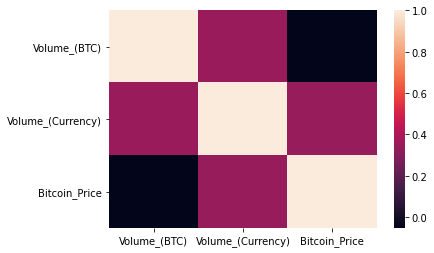

In [ ]:
sns.heatmap(corr)

(0.0, 69113.3034433464)

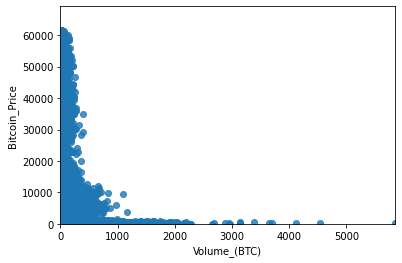

In [ ]:
#checking the linear relationship b/w "Volume_(BTC)" & "Bitcoin_Price"
sns.regplot(x="Volume_(BTC)", y="Bitcoin_Price", data=df)# We can't understand any relationship between these two variables
plt.ylim(0,)

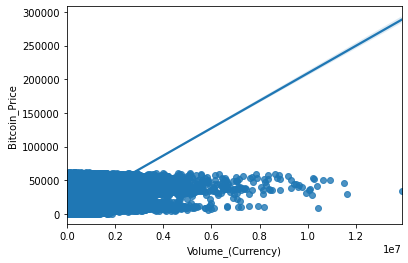

In [ ]:
#checking the linear relationship b/w "Volume_(Currency)" & "Bitcoin_Price"
sns.regplot(x="Volume_(Currency)", y="Bitcoin_Price", data=df)# There is some relationship exists between these two variables

P-value is the probability value which shows that the correlation between the two 
variables is statistically significant. Normally, we choose a significance level of 0.05 i.e P-value < 0.05.

In [ ]:
#Checking p-value of "Volume_(BTC"
pearson_coef, p_value = stats.pearsonr(df['Volume_(BTC)'], df['Bitcoin_Price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
if p_value < 0.05:
  print('Correlation is significant')
else:
  print('Correlation is not significant')

The Pearson Correlation Coefficient is -0.051887117191206825  with a P-value of P = 0.0
Correlation is significant


We can see that p_value is statistically significant although linear relationship is weak.

In [ ]:
#***********************************8
#Checking p-value of "Volume_(Currency)"
pearson_coef, p_value = stats.pearsonr(df['Volume_(Currency)'], df['Bitcoin_Price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
if p_value < 0.05:
  print('Correlation is significant')
else:
  print('Correlation is not significant')

The Pearson Correlation Coefficient is 0.3440098816123295  with a P-value of P = 0.0
Correlation is significant


In [ ]:
df.columns


Index(['Timestamp', 'Volume_(BTC)', 'Volume_(Currency)', 'Bitcoin_Price'], dtype='object')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f36c62d1090>,
      dtype=object)

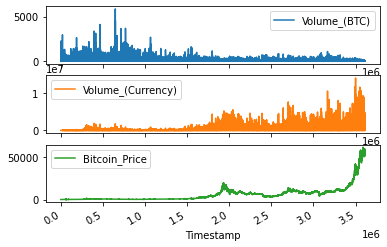

In [ ]:
df['Timestamp'] = df.index #reseting "Timestamp" from index to column, only to plot the data w.r.t Timestamp 
df.set_index('Timestamp')[['Volume_(BTC)',
       'Volume_(Currency)', 'Bitcoin_Price']].plot(subplots=True) #Before this command it is important to convert into timestamp format because it plot the data w.r.t timestamp. This command is some of the commands that are used to plot time series data.We set the Timestamp as index by using 'Volume_(BTC)' command.

In [ ]:
df.columns

Index(['Timestamp', 'Volume_(BTC)', 'Volume_(Currency)', 'Bitcoin_Price'], dtype='object')

It look like that the data is non-stationary. The stationary data have constant statistical properties like mean, variance and covariance.(Also autocorelation etc).

In [27]:
#To check wheather our data is stationary or non_stationary we are going to perform Augmented Dickey-Fuller Test

def stationarity_check(time_series):
  results=adfuller(time_series)
  print("Test_statistics=",results[0],'  P_value=' , results[1], "     Lags_used =",results[2],"   Number of Observation Used =",results[3],"  P_value Statistics=  ",results[4])


In [ ]:
#stationarity checking for "Bitcoin_Price"
stationarity_check(df['Bitcoin_Price'])
# "Test_statistics" more negitive mean more likely to be stationary
#If "P_Value" is less than 0.05 than it must be stationary and we will reject our Null Hypothesis

Test_statistics= 6.185633110386273   P_value= 1.0      Lags_used = 29    Number of Observation Used = 3346   P_value Statistics=   {'1%': -3.4323058648629248, '5%': -2.862404186780598, '10%': -2.5672300237626606}


If we print the "results" completly we can see that fourth element of our resulted touple gives us the dictionary which contain the critical test statistics. (At second position of this dictionary)We can see that Test_statistics value should be below mentioned value (of key 5%) if we want P_value of 5% or 0.05.

In [ ]:
#stationarity checking for "Volume_(BTC)"
stationarity_check(df['Volume_(BTC)'])

Test_statistics= -4.365828512891947   P_value= 0.00034100930475285915      Lags_used = 29    Number of Observation Used = 3346   P_value Statistics=   {'1%': -3.4323058648629248, '5%': -2.862404186780598, '10%': -2.5672300237626606}


In [ ]:
#stationarity checking for 'Volume_(Currency)'
stationarity_check(df['Volume_(Currency)'])

Test_statistics= -2.794664696742418   P_value= 0.0590399289296035      Lags_used = 28    Number of Observation Used = 3347   P_value Statistics=   {'1%': -3.432305280050264, '5%': -2.8624039284695777, '10%': -2.5672298862441107}


A second Test we can also perform to check the stationarity of our data. Splitting the timeseries into two or more partition and checking the mean and variance of each. 

In [ ]:
df.shape


(3376, 4)

In [ ]:
#splitting dataframe into two
df1=df[0:1600]
df2=df[1600:3376]

In [ ]:
#Checking the mean of df1
df1.mean()

Volume_(BTC)           14.174395
Volume_(Currency)    3283.919746
Bitcoin_Price         263.184304
dtype: float64

In [ ]:
#Checking the mean of df2
df2.mean()

Volume_(BTC)             6.915387
Volume_(Currency)    57472.693604
Bitcoin_Price         8517.641430
dtype: float64

We can see that both dataframes have different mean values so we have not constant mean in whole dataframe. Now checking the variance.

In [ ]:
df1.var()

Volume_(BTC)         1.129609e+02
Volume_(Currency)    2.228439e+07
Bitcoin_Price        5.300281e+04
dtype: float64

In [ ]:
df2.var()

Volume_(BTC)         2.377378e+01
Volume_(Currency)    6.075335e+09
Bitcoin_Price        9.571215e+07
dtype: float64

So it is clear that our timeseries is non-stationary. So, first of all we will make it stationary. There are multiple method to convert non-stationary timeseries into stationary form.

1.   Differencing or Seasonal Differencing
2.   Transformation
3.    Rolling Statistics


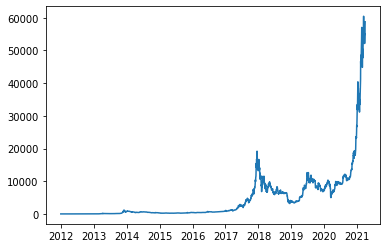

In [ ]:
#Checking the trend of "Bitcoin_Price"
plt.plot(df['Bitcoin_Price'])


We are going to use differencing method first.

In [29]:
df

,Volume_(BTC),Volume_(Currency),Bitcoin_Price
Timestamp,,,
2011-12-31 07:52:00,0.455581,2.000000,4.390000
2011-12-31 15:50:00,48.000000,210.720000,4.390000
2011-12-31 16:59:00,37.862297,171.380338,4.526411
2011-12-31 17:00:00,9.000000,41.220000,4.580000
2012-01-01 04:16:00,1.502000,6.879160,4.580000
...,...,...,...
2021-03-30 23:56:00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,1.705682,100117.070370,58696.198496


In [29]:
#We are going to make another column where we can store our difference(Using differencing method)
#df['Bitcoin_Price_df'] = df['Bitcoin_Price'] - df['Bitcoin_Price'].shift(1)#"shift(1)" we want to subtract the last value
#df['Bitcoin_Price_df'].head(3)



Timestamp
2011-12-31 07:52:00         NaN
2011-12-31 15:50:00    0.000000
2011-12-31 16:59:00    0.136411
Name: Bitcoin_Price_df, dtype: float64

In [ ]:
#Removing the NAN values(Because there is no value before first value to make difference so there is a NAN in the beginning)

#df.dropna(subset=["Bitcoin_Price_df"], axis=0, inplace=True)

# reset index, because we droped many rows
#df.reset_index(drop=True, inplace=True)
#df.head(10)

In [ ]:
#stationarity_check(df['Bitcoin_Price_df'])

In [ ]:

#df['Bitcoin_Price_df'].plot()

Checking some other methods

In [ ]:
#Using Transformation method we are trying to make our data stationary
#df['Bitcoin_Price_log']=np.log(df['Bitcoin_Price'])#log calculation
#df['Bitcoin_Price_sqrt']=np.sqrt(df['Bitcoin_Price'])#square root calculatiion
#df['Bitcoin_Price_cbrt']=np.cbrt(df['Bitcoin_Price'])#cube root calculation
#Differencing these time series
#df['BC_log']=df['Bitcoin_Price_log']-df['Bitcoin_Price_log'].shift(1)
#df['BC_sqrt']=df['Bitcoin_Price_sqrt']-df['Bitcoin_Price_sqrt'].shift(1)
#df['BC_cbrt']=df['Bitcoin_Price_cbrt']-df['Bitcoin_Price_cbrt'].shift(1)
#removing NAN values
#df[['BC_log']].dropna(inplace=True)
#df[['BC_sqrt']].dropna(inplace=True)
#df[['BC_cbrt']].dropna(inplace=True)

In [ ]:
#df

In [ ]:
#df.dropna(subset=["BC_cbrt"], axis=0, inplace=True)

# reset index, because we droped many rows
#df.reset_index(drop=True, inplace=True)
#df.head(10)

In [ ]:
#stationarity_check(df['BC_log'])

In [ ]:
#Plotting 
#df['BC_log'].plot()

In [ ]:
#df['BC_sqrt'].plot()

In [ ]:
#df['BC_cbrt'].plot()

In [ ]:
d_frame.head(5)

,Timestamp,Volume_(BTC),Volume_(Currency),Bitcoin_Price
Timestamp,,,,
2011-12-31 07:52:00,2011-12-31 07:52:00,0.455581,2.000000,4.390000
2011-12-31 15:50:00,2011-12-31 15:50:00,48.000000,210.720000,4.390000
2011-12-31 16:59:00,2011-12-31 16:59:00,37.862297,171.380338,4.526411
2011-12-31 17:00:00,2011-12-31 17:00:00,9.000000,41.220000,4.580000
2012-01-01 04:16:00,2012-01-01 04:16:00,1.502000,6.879160,4.580000


In [ ]:
d_frame.index = d_frame.Timestamp
# Resampling datframe on daily frequency basis
df_day = d_frame.resample('D').mean()

# # Resampling datframe on monthly frequency basis
df_m = d_frame.resample('M').mean()

# # Resampling datframe on anual frequency basis
df_y = d_frame.resample('A-DEC').mean()

# # Resampling datframe on quarterly frequency basis
df_Q = d_frame.resample('Q-DEC').mean()# For making it short after analysing these all data sets we are going to df_m for our further analysis


In [1]:
df_m.head(5)

NameError: ignored

In [ ]:


#We are going to make another column where we can store our difference(Using differencing method)
d_frame['Bitcoin_Price_df'] = df_m['Bitcoin_Price'] - df_m['Bitcoin_Price'].shift(1)#"shift(1)" we want to subtract the last value
#df[['Bitcoin_Price_df']]

# simply drop whole rows with NaN in "Bitcoin_Price" column
d_frame.dropna(subset=["Bitcoin_Price_df"], axis=0, inplace=True)

# reset index, because we droped many rows
d_frame.reset_index(drop=True, inplace=True)
d_frame.head(10)

stationarity_check(d_frame['Bitcoin_Price_df'])

MissingDataError: ignored

In [ ]:
df.describe()

We can see that our data have many outliers in almost all columns.

In [ ]:
df.query('Bitcoin_Price>8.627637e+03')# We have used 75% value to check outliers.

In [ ]:
df.query('Bitcoin_Price<4.438306e+02')# We have used 25% value to check outliers. 

In [ ]:
df.columns

In [ ]:
df_in=df[['Volume_(BTC)',
       'Volume_(Currency)', 'Bitcoin_Price']]  # Time stamp is not included in input dataframe

We can also check other colums for number of outliers. Standard scaler will not account the outliers so we use "MinMaxScaler"

In [ ]:
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(df_in)
scaled_data #Data is b/w 0 and 1

In [ ]:
features=scaled_data           #(Multivariate data going to be the input of LSTM model)All columns including 'Weighted_Price' because we want to predict future values using past values of 'Weighted_Price' along with other variables (Timestamp is not icluded). All
target=scaled_data[:,-1]        #only 'Weighted_Price' column (Timestamp is not included)

In [ ]:
features

In [ ]:
target

In [ ]:
features.shape

In [ ]:
target.shape

In [ ]:
# Splitting the Training and Test data
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.0090,random_state=42,shuffle=False)

In [ ]:
x_train.shape

In [ ]:
x_test.shape #We wnant to predict the price of Bitcoin in the spam of one month

In [ ]:
y_train.shape

In [ ]:
y_test.shape

### 6- Model Development and Compilation

In [ ]:
win_length=30
batch_size=32
num_features=3
# Time series generator is used to prepare data.Feature column(x_train or x_test) & Target column(y_train,y_test) are passed.
#window_length is number of time periods of data. It will take these numbers of time periods of data and predict the next.
train_generator=TimeseriesGenerator(x_train,y_train,length=win_length,sampling_rate=1,batch_size=batch_size)
test_generator=TimeseriesGenerator(x_test,y_test,length=win_length,sampling_rate=1,batch_size=batch_size)

train_generator[0] #it will contain 32 observations equal to "batch_size" each have further observations equal to "win_length" & further each observation contain equal to "num_features" features.The are also 32 target columns equel to batch size 

In [ ]:
model = Sequential()
# In following line of code,128 is LSTM output.We set"return_sequences=True" because we require hidden state for each of our input data otherwise it will return
#only one hidden state for all the input data.it is time series data so we need to have hidde state for each and every observation.
model.add(LSTM(128,input_shape=(win_length,num_features),return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))# return only single hidden state. If we want to further use other layers before final layer we can set it equel to true.
model.add(Dropout(0.3))
model.add(tf.keras.layers.Dense(1))
print(model.summary())

In [ ]:
# Early stopping is if our validation loss is not improving then it will stop the training earlier.it will observe 2 iterations for validation loss improvement.
earl_stop=EarlyStopping(monitor="val_loss",patience=2,mode='min')

In [ ]:
#Compiling the model
model.compile(loss = MeanSquaredError(), optimizer=Adam(),metrics =[MeanAbsoluteError()])

### 7-Model Training 

In [ ]:
epochs=30
#Training our model
history=model.fit_generator(train_generator,epochs=epochs,validation_data=test_generator,shuffle=False,callback=earl_stop)

In [ ]:
#saving the model

model_json = model.to_json()
with open("model_final.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("final_model.h5")

### 8-Model Evaluation and Prediction

In [ ]:
model.evaluate(test_generator,verbose=0)# checking the performance of our model

In [ ]:
predict=model.predict_generator(test_generator)

In [ ]:
predict